In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import time
import timeit
import datetime
import http.client
import requests
import json

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from heapq import *
import planarity

# S&P500 Data Processing&Statistics

In [88]:
changes_df = pd.read_excel('S&P500 changes.xlsx',index_col='date')
changes_df.index = pd.to_datetime(changes_df.index)
changes_df = changes_df.loc['2017-04-01':]
changes_df.tail()

<ipython-input-88-0e917c9ae7a8>:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  changes_df = changes_df.loc['2017-04-01':]


,Added Ticker,Added Security,Removed Ticker,Removed Security,Reason
date,,,,,
2017-06-19,ANSS,Ansys,R,Ryder System,Market capitalization changes.[74]
2017-06-19,RE,Everest Re,MJN,Mead Johnson,Reckitt Benckiser acquired Mead Johnson Nutrit...
2017-06-02,INFO,IHS Markit,TGNA,Tegna,TGNA spins off Cars.com[76]
2017-04-05,IT,Gartner,DNB,Dun & Bradstreet,IT acquiring CEB[77]
2017-04-04,DXC,DXC Technology,SWN,Southwestern Energy,"HPE spins off Everett, merged with CSC to form..."


In [89]:
cur_components_df = pd.read_excel('S&P500 current components.xlsx')
cur_components_df.head()

,Symbol,Security,SEC filings,GICS聽Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,A,Agilent Technologies,reports,Health Care,Health Care Equipment,"Santa Clara, California",36682,1090872,1999
1,AAL,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",42086,6201,1934
2,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",42194,1158449,1932
3,AAPL,Apple Inc.,reports,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",30285,320193,1977
4,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",41274,1551152,2013 (1888)


In [94]:
# generate SP500 components from now to historical periods.
# initialize
components_mark_df = pd.DataFrame()
prev_date = 0
stocks = list(cur_components_df['Symbol'])
# generate historical components based on changes
for date in changes_df.index[:-1]:
    if date != prev_date:
        components_mark_df.loc[date, stocks] = 1
        prev_date = date
        removed = changes_df.loc[date, 'Removed Ticker']
        added = changes_df.loc[date, 'Added Ticker']
        
        if type(removed) == str:
            stocks.append(removed)            
        elif isinstance(removed, pd.Series):
            for ele in list(removed.values):
                if type(ele) == str: stocks.append(ele)
                    
        if type(added) == str:
            stocks.remove(added)
        elif isinstance(added, pd.Series):
            for ele in list(added.values):
                if type(ele) == str: stocks.remove(ele)
                    
components_mark_df = components_mark_df.sort_index()
components_mark_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,RIG,BBBY,MUR,MNK,RAI,YHOO,TDC,R,MJN,TGNA
2017-04-05,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-06-02,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2017-06-19,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2017-07-26,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-08,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# save results
components_mark_df.index.name = 'date'
components_mark_df.to_csv('components_mark_df.csv')

In [105]:
'''
# Use Yahoo Finance API to retrive all the prices of 600+ stocks
conn = http.client.HTTPSConnection("yahoofinance-stocks1.p.rapidapi.com")
headers = {
    'X-RapidAPI-Key': "c3d37faa96msh4a93641804d5669p116e33jsnfd6f8414a59b",
    'X-RapidAPI-Host': "yahoofinance-stocks1.p.rapidapi.com"
    }

#components_price_df = pd.DataFrame(columns=components_mark_df.columns)

for tick in components_price_df.columns:
    # retrive information for stock tick
    if components_price_df[tick].isnull().values.all():
        conn.request("GET", "/stock-prices?EndDateInclusive=2022-06-05&StartDateInclusive=2016-04-01&Symbol={}&OrderBy=Ascending".format(tick), headers=headers)
        res = conn.getresponse()
        time.sleep(0.5)
        try:
            data = json.loads(res.read().decode("utf-8"))
            for item in data['results']:
                try:
                    date_index = pd.to_datetime(item['date'])
                    close = item['close']
                    components_price_df.loc[date_index, tick] = close
                except:
                    continue
        except:
            print("data for {} does not exist".format(tick))

components_price_df = components_price_df.sort_index()
components_price_df.to_csv('components_price_new.csv')
'''

In [104]:
components_price_df = pd.read_csv('components_price_new.csv',index_col='date')

In [117]:
components_price_df = pd.read_csv('components_price_new.csv',index_col='date')
components_price_df.index = pd.to_datetime(components_price_df.index)
#components_price_df = components_price_df
for tick in components_price_df.columns:
    # delete stock whose information can not be retrived
    if components_price_df[tick].isnull().values.all():
        components_price_df = components_price_df.drop(columns=[tick])
        #print(tick)
        continue
    # process abnormal data
    for d in components_price_df.index:
        if type(components_price_df.loc[d,tick]) == str:
            components_price_df.loc[d,tick]=np.nan
        else:
            if components_price_df.loc[d,tick]<0 or components_price_df.loc[d,tick]>9999:
                components_price_df.loc[d,tick]=np.nan
# fillna with previous price
components_price_df = components_price_df.fillna(method="ffill")
components_price_df = components_price_df.fillna(method="bfill")

In [119]:
components_mark_df = components_mark_df[components_price_df.columns]

In [120]:
components_ret_df = ((components_price_df/components_price_df.shift())-1).iloc[1:]
print(f"There are {components_ret_df.shape[0]} rows and {components_ret_df.shape[1]} columns in the dataset.")
print(f"Data timeperiod covers: {components_ret_df.index[0]} to {components_ret_df.index[-1]}")
components_ret_df.head()

There are 1571 rows and 566 columns in the dataset.
Data timeperiod covers: 2016-04-04 00:00:00 to 2022-06-28 00:00:00


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,PDCO,CHK,SNI,AN,RIG,BBBY,MUR,TDC,R,TGNA
date,,,,,,,,,,,,,,,,,,,,,
2016-04-04,-0.007442,-0.003796,-0.007418,0.010274,0.031174,0.007514,-0.009112,0.003081,-0.007306,-0.006936,...,0.001726,0.0,-0.002225,-0.010689,-0.003497,-0.004847,-0.018137,-0.012086,-0.009034,-0.018851
2016-04-05,-0.018745,-0.011176,0.007788,-0.011789,-0.011316,-0.016866,-0.005852,-0.006616,-0.011861,-0.003492,...,-0.028645,0.0,-0.008623,0.007277,0.010526,-0.004262,-0.013854,-0.007103,-0.017762,-0.005809
2016-04-06,0.024962,-0.000771,-0.003677,0.010473,0.023061,0.021589,0.021863,0.024025,0.004731,0.013062,...,0.016630,0.0,0.007199,0.007662,0.004630,-0.005096,0.049383,0.017886,-0.011522,0.031910
2016-04-07,-0.019135,-0.013882,-0.025332,-0.021810,-0.009851,-0.010053,-0.016252,-0.010221,-0.022412,-0.016981,...,-0.020720,0.0,-0.030226,-0.019770,-0.031106,0.003278,-0.008519,-0.016790,-0.020884,-0.021341
2016-04-08,0.001773,0.003650,0.001797,0.001106,-0.013997,-0.015578,0.006378,-0.005633,0.006512,0.003092,...,0.000891,0.0,0.000768,-0.010417,0.030916,-0.040433,0.051146,-0.009531,0.024306,0.009346


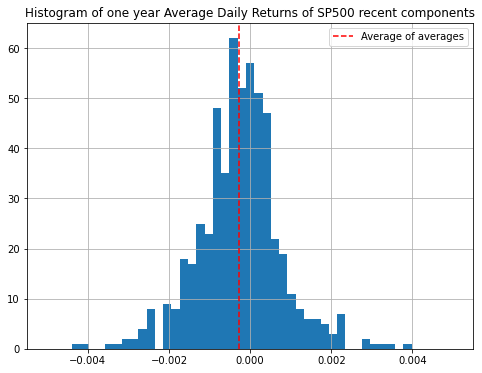

In [123]:
# one year return of SP500 recent components
active_components = components_mark_df[components_mark_df.iloc[[-1],:]==1].columns

plt.figure(figsize=(8,6))
plt.title('Histogram of one year Average Daily Returns of SP500 recent components')
components_ret_df[active_components].loc['2021-06-01':'2022-06-28'].mean().hist(bins=np.linspace(-.005,.005, 50))
plt.axvline(components_ret_df[active_components].loc['2021-06-01':'2022-06-28'].mean().mean(), color='red', linestyle='--', label = 'Average of averages')
plt.legend()
plt.show();

In [124]:
correlation_matrix = components_ret_df[active_components].loc['2021-06-01':'2022-06-28'].corr()
correlation_matrix = correlation_matrix.fillna(value=0.0001)
correlation_matrix.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,PDCO,CHK,SNI,AN,RIG,BBBY,MUR,TDC,R,TGNA
A,1.000000,0.321970,0.343723,0.590099,0.206113,0.303739,0.598548,0.612774,0.631346,0.680844,...,0.295054,0.134905,0.0001,0.215848,0.066236,0.219321,0.110618,0.307659,0.344350,0.143346
AAL,0.321970,1.000000,0.354378,0.492916,0.039215,0.300702,0.443424,0.226443,0.416960,0.350634,...,0.283800,0.210032,0.0001,0.319516,0.243040,0.324434,0.321063,0.402536,0.430593,0.280313
AAP,0.343723,0.354378,1.000000,0.409693,0.269604,0.342982,0.308804,0.284990,0.468702,0.320679,...,0.286270,0.199091,0.0001,0.511389,0.118431,0.212947,0.257044,0.273571,0.410796,0.219772
AAPL,0.590099,0.492916,0.409693,1.000000,0.184751,0.374868,0.564246,0.469883,0.670667,0.662270,...,0.340060,0.202983,0.0001,0.252588,0.208557,0.272564,0.245131,0.383238,0.414400,0.157167
ABBV,0.206113,0.039215,0.269604,0.184751,1.000000,0.455902,0.099448,0.344642,0.291643,0.131132,...,0.282016,0.189248,0.0001,0.118242,0.087050,-0.002865,0.144596,0.091903,0.041544,0.112238


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


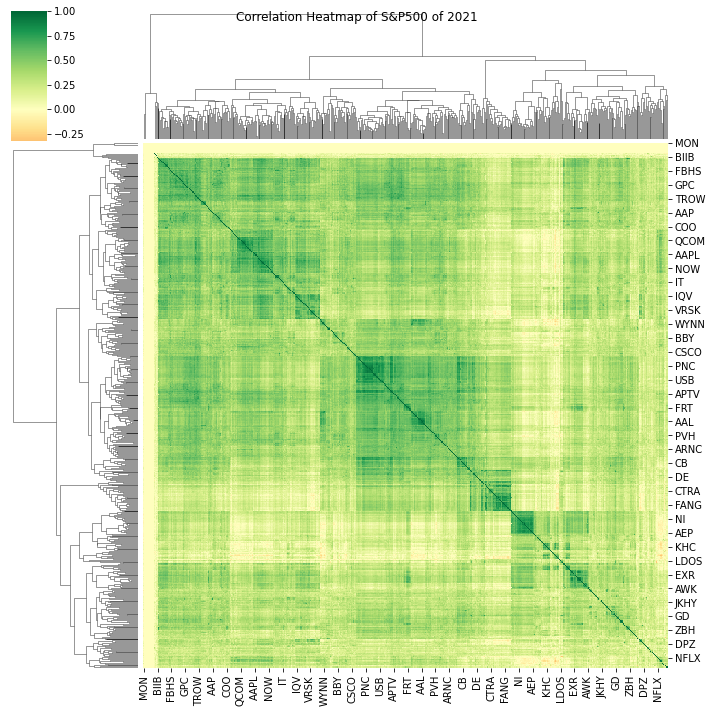

In [125]:
sns.clustermap(correlation_matrix, cmap="RdYlGn", center =0.).fig.suptitle('Correlation Heatmap of S&P500 of 2021');

# Graph Filter Algorithm

In [126]:
def PMFG(G):
    # sort edges weight in descending order
    h = []
    for u,v,d in G.edges(data=True):
        heappush(h,(d['weight'],u,v))
    heapsort = [heappop(h) for i in range(len(h))]
    heapsort.reverse()
    
    # PMFG algorithm
    res = nx.Graph()
    for (w,u,v) in heapsort:
        res.add_edge(u,v,weight=w)
        if not planarity.is_planar(res):
            res.remove_edge(u,v)
            
        if res.number_of_edges() == 3*(G.number_of_nodes()-2):
            break   

    return res

In [127]:
def MST(G):
    # sort edges weight in descending order
    h = []
    for u,v,d in G.edges(data=True):
        heappush(h, (d['weight'],u,v))
    heapsort = [heappop(h) for i in range(len(h))]
    heapsort.reverse()
    
    # kruskal MST algorithm
    def find_subtree(parent, i):
        # i represents index of nodes
        if parent[i] == i:
            return i
        return find_subtree(parent, parent[i])
            
    res = nx.Graph()
    parent = [j for j in range(len(G.nodes))]
    subtree_sizes = [0]*len(G.nodes)
    i = 0
    e = 0 # number of edges in MST
    
    while e<(len(G.nodes)-1):
        w, u, v = heapsort[i]
        i += 1
        u_index = list(G.nodes).index(u)
        v_index = list(G.nodes).index(v)
        x = find_subtree(parent, u_index)
        y = find_subtree(parent, v_index)
        # if u and v belongs to different subtree
        if x!=y:
            e += 1
            res.add_edge(u, v, weight = w)
            # connect two trees
            parent[y] = x
    return res 

In [ ]:
def FULL(G):
    # sort edges weight in descending order
    h = []
    threshold = 0.5
    
    for u,v,d in G.edges(data=True):
        if d['weight'] > threshold:
            heappush(h,(d['weight'],u,v))
    heapsort = [heappop(h) for i in range(len(h))]
    heapsort.reverse()    
    
    res = nx.Graph()
    for (w,u,v) in heapsort:
        res.add_edge(u,v,weight=w) 

    return res

In [128]:
# graph from corr
G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))

In [15]:
G0_PMFG = PMFG(G0)

In [16]:
G0_MST = MST(G0)

In [17]:
print('Nodes number of original graph: ',len(list(G0.nodes)))
print('Nodes number of PMFG graph: ',len(list(G0_PMFG.nodes)))
print('Nodes number of MST graph: ',len(list(G0_MST.nodes)))
print('Edges number of original graph: ',len(list(G0.edges)))
print('Edges number of PMFG graph: ',len(list(G0_PMFG.edges)))
print('Edges number of MST graph: ',len(list(G0_MST.edges)))

Nodes number of original graph:  540
Nodes number of PMFG graph:  540
Nodes number of MST graph:  540
Edges number of original graph:  145530
Edges number of PMFG graph:  1614
Edges number of MST graph:  539


# Generate Monthly Rank By Centrality 2019-2022

In [133]:
dateindex_new = []
year_prev, month_prev = 0, 0
# Extract the first available day at every month from 2019 
for date in components_price_df.index:
    if date.year >= 2017:
        if ((date.year != year_prev) or (date.month != month_prev)):
            dateindex_new.append(date)
            year_prev = date.year
            month_prev = date.month
dateindex_new = pd.to_datetime(dateindex_new)[5:]
dateindex_new

DatetimeIndex(['2017-06-01', '2017-07-03', '2017-08-01', '2017-09-01',
               '2017-10-02', '2017-11-01', '2017-12-01', '2018-01-02',
               '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-01',
               '2018-06-01', '2018-07-02', '2018-08-01', '2018-09-04',
               '2018-10-01', '2018-11-01', '2018-12-03', '2019-01-02',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-03', '2019-07-01', '2019-08-01', '2019-09-03',
               '2019-10-01', '2019-11-01', '2019-12-02', '2020-01-02',
               '2020-02-03', '2020-03-02', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-03', '2020-09-01',
               '2020-10-01', '2020-11-02', '2020-12-01', '2021-01-04',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-03',
               '2021-06-01', '2021-07-01', '2021-08-02', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-03',
      

### MST

In [134]:
# rank dataframe
centrality_MST_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)
rank_MST_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)

In [143]:
for date in dateindex_new:
    # find lastest SP500 components
    temp = components_mark_df.loc[:date]
    temp = temp.iloc[-1,:]
    temp = temp[temp==1]
    latest_components = list(temp.index)
    # corr_matrix of latest_components (look back 1 year)
    correlation_matrix = components_ret_df[latest_components].loc[(date-datetime.timedelta(days=365)):date].corr()
    correlation_matrix = correlation_matrix.fillna(value=0.0001)
    # graph filter
    G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
    G0_MST = MST(G0)
    # centrality sorting(ascending) and ranking
    centrality = nx.closeness_centrality(G0_MST)
    centrality_sorted ={k: v for k, v in sorted(centrality.items(), key=lambda item: item[1])}
    centrality_rank = dict(zip(list(centrality_sorted.keys()),[i for i in range(len(centrality_sorted))]))
    # record values
    centrality_MST_df.loc[date, centrality.keys()] = list(centrality.values())
    rank_MST_df.loc[date, centrality_rank.keys()] = list(centrality_rank.values())

In [144]:
centrality_MST_df.to_csv('centrality_MST_df.csv')
rank_MST_df.to_csv('rank_MST_df.csv')

### PMFG

In [180]:
# rank dataframe
centrality_PMFG_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)
rank_PMFG_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)

In [ ]:
for date in dateindex_new:
    # find lastest SP500 components
    temp = components_mark_df.loc[:date]
    temp = temp.iloc[-1,:]
    temp = temp[temp==1]
    latest_components = list(temp.index)
    # corr_matrix of latest_components (look back 1 year)
    correlation_matrix = components_ret_df[latest_components].loc[(date-datetime.timedelta(days=255)):date].corr()
    correlation_matrix = correlation_matrix.fillna(value=0.0001)
    # graph filter
    G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
    G0_PMFG = PMFG(G0)
    # centrality sorting(ascending) and ranking
    centrality = nx.closeness_centrality(G0_PMFG)
    centrality_sorted ={k: v for k, v in sorted(centrality.items(), key=lambda item: item[1])}
    centrality_rank = dict(zip(list(centrality_sorted.keys()),[i for i in range(len(centrality_sorted))]))
    # record values
    centrality_PMFG_df.loc[date, centrality.keys()] = list(centrality.values())
    rank_PMFG_df.loc[date, centrality_rank.keys()] = list(centrality_rank.values())

In [ ]:
centrality_PMFG_df.to_csv('centrality_PMFG_df.csv')
rank_PMFG_df.to_csv('rank_PMFG_df.csv')

### Full Network

In [ ]:
# rank dataframe
centrality_FULL_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)
rank_FULL_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)

In [ ]:
for date in dateindex_new:
    # find lastest SP500 components
    temp = components_mark_df.loc[:date]
    temp = temp.iloc[-1,:]
    temp = temp[temp==1]
    latest_components = list(temp.index)
    # corr_matrix of latest_components (look back 1 year)
    correlation_matrix = components_ret_df[latest_components].loc[(date-datetime.timedelta(days=255)):date].corr()
    correlation_matrix = correlation_matrix.fillna(value=0.0001)
    # graph filter
    G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
    G0_FULL = FULL(G0)
    # centrality sorting(ascending) and ranking
    centrality = nx.closeness_centrality(G0_FULL)
    centrality_sorted ={k: v for k, v in sorted(centrality.items(), key=lambda item: item[1])}
    centrality_rank = dict(zip(list(centrality_sorted.keys()),[i for i in range(len(centrality_sorted))]))
    # record values
    centrality_FULL_df.loc[date, centrality.keys()] = list(centrality.values())
    rank_FULL_df.loc[date, centrality_rank.keys()] = list(centrality_rank.values())

In [ ]:
centrality_FULL_df.to_csv('centrality_FULL_df.csv')
rank_FULL_df.to_csv('rank_FULL_df.csv')

# Back Test

In [156]:
components_ret_df

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,PDCO,CHK,SNI,AN,RIG,BBBY,MUR,TDC,R,TGNA
date,,,,,,,,,,,,,,,,,,,,,
2016-04-04,-0.007442,-0.003796,-0.007418,0.010274,0.031174,0.007514,-0.009112,0.003081,-0.007306,-0.006936,...,0.001726,0.000000,-0.002225,-0.010689,-0.003497,-0.004847,-0.018137,-0.012086,-0.009034,-0.018851
2016-04-05,-0.018745,-0.011176,0.007788,-0.011789,-0.011316,-0.016866,-0.005852,-0.006616,-0.011861,-0.003492,...,-0.028645,0.000000,-0.008623,0.007277,0.010526,-0.004262,-0.013854,-0.007103,-0.017762,-0.005809
2016-04-06,0.024962,-0.000771,-0.003677,0.010473,0.023061,0.021589,0.021863,0.024025,0.004731,0.013062,...,0.016630,0.000000,0.007199,0.007662,0.004630,-0.005096,0.049383,0.017886,-0.011522,0.031910
2016-04-07,-0.019135,-0.013882,-0.025332,-0.021810,-0.009851,-0.010053,-0.016252,-0.010221,-0.022412,-0.016981,...,-0.020720,0.000000,-0.030226,-0.019770,-0.031106,0.003278,-0.008519,-0.016790,-0.020884,-0.021341
2016-04-08,0.001773,0.003650,0.001797,0.001106,-0.013997,-0.015578,0.006378,-0.005633,0.006512,0.003092,...,0.000891,0.000000,0.000768,-0.010417,0.030916,-0.040433,0.051146,-0.009531,0.024306,0.009346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-22,-0.000702,0.004601,0.017062,-0.003827,0.028508,0.012285,0.017350,0.009865,0.012981,0.006446,...,0.008897,-0.009096,0.000000,0.008611,-0.064690,-0.019403,-0.066121,-0.006790,-0.003618,-0.003817
2022-06-23,0.042179,-0.009160,0.022730,0.021574,0.012808,-0.002896,0.052137,0.007303,-0.001990,0.030958,...,-0.002822,-0.077908,0.000000,-0.006670,-0.054755,0.085236,-0.017857,0.033908,-0.017458,0.012931
2022-06-24,0.022681,0.070878,0.025024,0.024517,0.019338,0.026694,0.026949,0.030506,0.047371,0.029418,...,0.007075,0.097721,0.000000,0.041450,0.064024,-0.018233,0.019139,0.051309,0.011230,0.013239


In [170]:
ret_df = pd.DataFrame(index = components_ret_df.index, columns = ['euqal_weight','MST_top','MST_bottom','PMFG_top','PMFG_bottom']).loc['2019-06-01':]

In [177]:
num = 5
for date in ret_df.index:
    prev_date = 0
    for temp_date in dateindex_new:
        if temp_date <= date:
            prev_date = temp_date
        else:
            break

    # MST
    temp = rank_MST_df.loc[prev_date]
    max_rank = temp.max()
    total = list(temp[temp>=0].index)
    ret_df.loc[date,'euqal_weight'] = components_ret_df.loc[date, total].mean()
    top = list(temp[temp < num].index)
    bottom = list(temp[temp > (max_rank-num)].index)
    ret_df.loc[date,'MST_top'] = components_ret_df.loc[date, top].mean()
    ret_df.loc[date,'MST_bottom'] = components_ret_df.loc[date, bottom].mean()
    # PMFG
    '''
    temp = rank_PMFG_df.loc[prev_date]
    max_rank = temp.max()
    top = list(temp[temp < num].index)
    bottom = list(temp[temp > (max_rank-num)].index)
    ret_df.loc[date,'PMFG_top'] = components_ret_df.loc[date, top].mean()
    ret_df.loc[date,'PMFG_bottom'] = components_ret_df.loc[date, bottom].mean()
    '''

In [178]:
ret_df

,euqal_weight,MST_top,MST_bottom,PMFG_top,PMFG_bottom
date,,,,,
2019-06-03,0.005845,0.007555,0.013274,NaN,NaN
2019-06-04,0.022299,0.021812,0.018595,NaN,NaN
2019-06-05,0.007053,0.00823,0.009811,NaN,NaN
2019-06-06,0.004281,0.010598,0.00278,NaN,NaN
2019-06-07,0.006616,0.01689,0.015933,NaN,NaN
...,...,...,...,...,...
2022-06-22,-0.000856,0.011112,-0.001863,NaN,NaN
2022-06-23,0.008036,0.018141,-0.002114,NaN,NaN
2022-06-24,0.032549,0.002468,0.03812,NaN,NaN


<AxesSubplot:xlabel='date'>

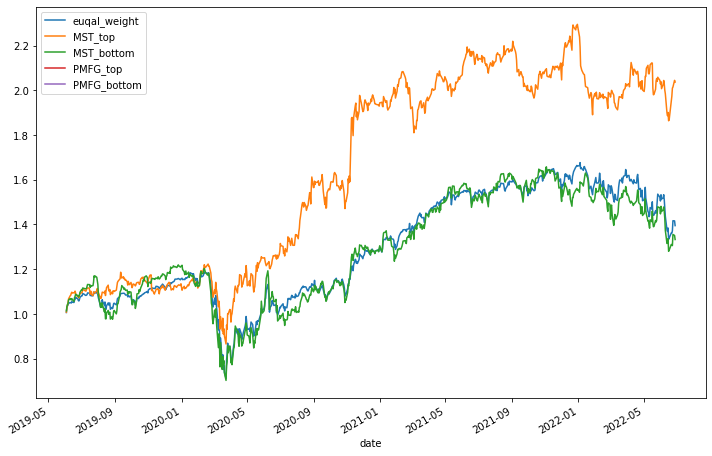

In [179]:
(ret_df+1).cumprod().plot(figsize=(12,8))

In [144]:
components_ret_df.loc[date, top]

AMT    -0.020923
ARE    -0.014038
CCI    -0.004791
DLR    -0.010064
EQIX   -0.011503
EXR    -0.033079
O      -0.005448
PLD    -0.020551
PSA    -0.024776
SBAC   -0.023521
Name: 2022-01-03 00:00:00, dtype: float64

In [121]:
temp = rank_MST_df.loc['2019-01-02']

In [129]:
len(list(temp[temp>=0].index))

474

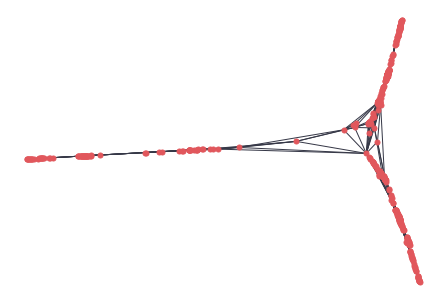

In [125]:
nx.draw(G0_PMFG, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(G0_PMFG))

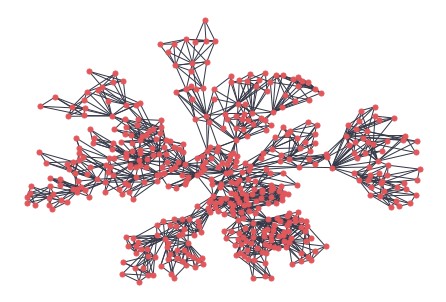

In [126]:
nx.draw(G0_PMFG, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G0_PMFG))

### MST

In [37]:
components_mark_df[components_mark_df.iloc[[-1],:]==1]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,BBWI,TECH.1,BRO,CDAY,MTCH,CTRA,EPAM.1,FDS,SBNY,SEDG
date,,,,,,,,,,,,,,,,,,,,,
2018-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# S&P constituents return data
use_IVV = False

if use_IVV:
    raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')

    log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
    # drop first row of raw prices so it has the same dimensions as the log-returns DF
    raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
    stock_names = log_returns_df.columns

    df_shape = (raw_asset_prices_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

    print(log_returns_df.head())
else:
    log_returns_df = pd.read_excel("data/historical_2016_2019.xlsx", index_col='Names Date')
    stock_names = log_returns_df.columns   # this is just simple returns, not log -- but whatevs
    df_shape = (log_returns_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {log_returns_df.index[0]} to {log_returns_df.index[-1]}")
    
ticker_names = log_returns_df.columns

There are 1006 rows and 485 columns in the dataset.
Data timeperiod covers: 2016-01-04 00:00:00 to 2019-12-31 00:00:00


In [3]:
log_returns_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Names Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.026788,-0.034002,0.011494,0.000855,-0.027515,-0.017742,-0.055826,-0.044088,-0.025550,-0.020971,...,-0.005848,-0.024910,-0.006286,-0.032703,-0.011507,-0.011499,-0.007603,-0.045370,-0.021612,-0.013564
2016-01-05,-0.003441,-0.009533,-0.006831,-0.025059,-0.004166,0.014626,-0.002816,-0.000233,0.005205,0.004023,...,0.010084,0.014847,0.008521,0.020387,-0.000277,-0.002493,0.020823,-0.025117,-0.010857,0.015655
2016-01-06,0.004439,0.017522,-0.026455,-0.019570,0.000174,-0.015286,0.003529,-0.008388,-0.001954,-0.014295,...,0.010538,-0.018287,-0.008321,-0.014486,-0.012476,-0.007080,0.004330,-0.039957,-0.029145,0.000208
2016-01-07,-0.042475,-0.018918,0.011073,-0.042205,-0.002963,-0.031932,-0.039625,-0.023966,-0.029366,-0.020984,...,0.003842,-0.039448,-0.016006,-0.008785,-0.025828,-0.034116,-0.022993,-0.045316,-0.030020,-0.030404
2016-01-08,-0.010513,-0.001978,-0.021971,0.005288,-0.027268,-0.005785,0.032471,-0.020944,-0.009681,-0.014140,...,-0.010935,-0.020534,-0.020202,-0.028635,-0.009510,-0.013607,-0.004217,-0.002693,-0.011254,-0.014605


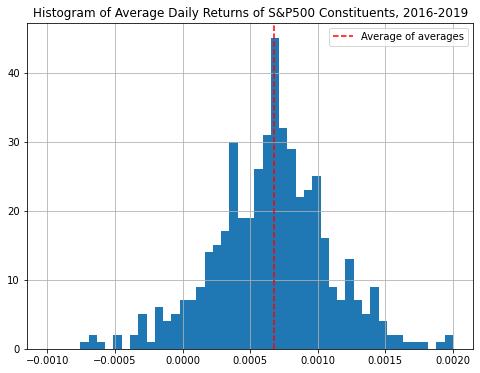

In [4]:
plt.figure(figsize=(8,6))
plt.title('Histogram of Average Daily Returns of S&P500 Constituents, 2016-2019')
log_returns_df.mean().hist(bins=np.linspace(-.001,.002, 50))
plt.axvline(log_returns_df.mean().mean(), color='red', linestyle='--', label = 'Average of averages')
plt.legend()
plt.show();

In [5]:
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of sample correlation matrix: 4.51e+04
Condition number of shrunk correlation matrix: 4.36e+04


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.382898,0.174961,0.423588,0.371440,0.268825,0.370766,0.574714,0.524620,0.524594,...,0.082312,0.390005,0.344952,0.305398,0.495933,0.383953,0.426343,0.385791,0.402954,0.508536
AAL,0.382898,1.000000,0.202168,0.349767,0.212754,0.242920,0.208959,0.356430,0.336261,0.357479,...,-0.061541,0.401709,0.242301,0.195624,0.393245,0.300815,0.274667,0.333879,0.422293,0.330460
AAP,0.174961,0.202168,1.000000,0.155419,0.147060,0.162803,0.134836,0.215587,0.215358,0.151175,...,0.068318,0.154732,0.180567,0.123950,0.209004,0.176603,0.188930,0.172971,0.265356,0.191637
AAPL,0.423588,0.349767,0.155419,1.000000,0.271367,0.206464,0.363831,0.425138,0.461773,0.513189,...,0.031991,0.442036,0.343888,0.223976,0.365499,0.315368,0.321466,0.350361,0.302726,0.384876
ABBV,0.371440,0.212754,0.147060,0.271367,1.000000,0.304759,0.258362,0.431498,0.328579,0.328576,...,0.059929,0.241190,0.292893,0.261174,0.302585,0.199634,0.334430,0.222451,0.278699,0.380533


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


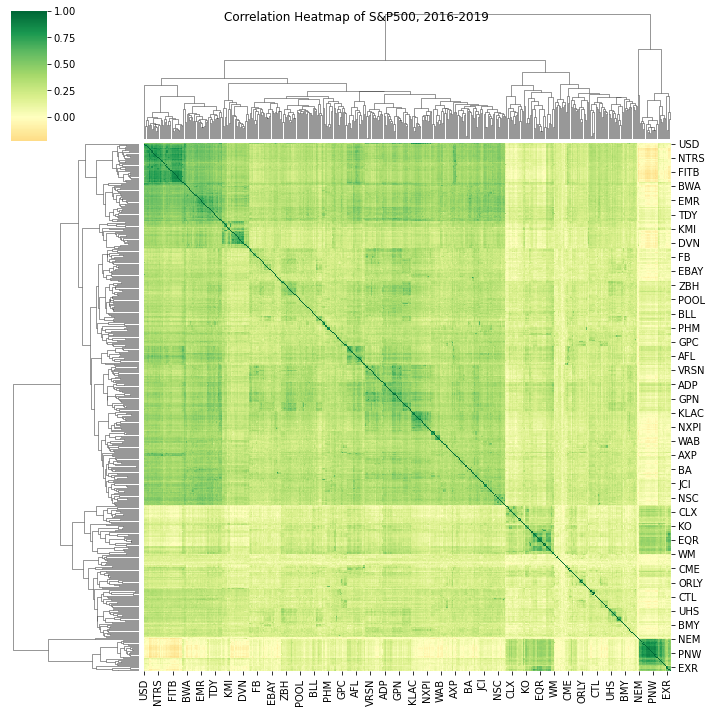

In [6]:
sns.clustermap(correlation_matrix, cmap="RdYlGn", center =0.).fig.suptitle('Correlation Heatmap of S&P500, 2016-2019');

# Graph Filter Algorithm